In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
dict_results={}


In [2]:
import os
import numpy as np
from sklearn.metrics import mean_squared_error
from scipy.stats.mstats import pearsonr
import pandas as pd 

testset = ['MEDIAEVAL17_00','MEDIAEVAL17_01','MEDIAEVAL17_02','MEDIAEVAL17_03','MEDIAEVAL17_04','MEDIAEVAL17_05','MEDIAEVAL17_06','MEDIAEVAL17_07','MEDIAEVAL17_08','MEDIAEVAL17_09','MEDIAEVAL17_10','MEDIAEVAL17_11','MEDIAEVAL17_12','MEDIAEVAL17_13' ]

dir_input ='fusedir/'
dir_results = 'teams/'
dir_gt = "ground_truth/"


In [3]:
sorted(os.listdir(dir_input))

['me17ei_BOUN-nku_valence_arousal_1.txt',
 'me17ei_BOUN-nku_valence_arousal_2.txt',
 'me17ei_BOUN-nku_valence_arousal_3.txt',
 'me17ei_BOUN-nku_valence_arousal_4.txt',
 'me17ei_BOUN-nku_valence_arousal_5.txt']

In [4]:
def read_groundtruth():
    names_gt = []
    valence_gt = []
    arousal_gt = []

    for test in testset:

        names_gt.append(test)

        valence = []
        arousal = []

        with open('ground_truth/' + test + '_Valence-Arousal.txt', 'r') as f:
            f.readline()  # Skip first line
            for line in f:
                lineParts = line.split()
                valence.append(float(lineParts[2]))
                arousal.append(float(lineParts[3]))

        valence_gt.append(valence)
        arousal_gt.append(arousal)

    return names_gt, valence_gt, arousal_gt


In [5]:
def read_valence_arousal(files=[]): 
    dict_val={}
    dict_ar={}
    if (len(files)<=0):
        files = sorted(os.listdir(dir_input))
    for fname in files:
        if fname.find('.txt') >= 0:
            print(fname)

            with open(dir_input+fname,'r') as f:
                lines = f.read().splitlines()
                #print(lines)

            dict_val[fname] ={}
            dict_ar[fname] ={}
            names=[]
            indexes = []
            for i in range(len(lines)):
                if lines[i].find("MEDIAEVAL17") >= 0:
                    indexes.append(i)
                    names.append(lines[i])

            for i in range(len(names)):
                ibeg = indexes[i]+1
                iend = indexes[i+1]-1 if i < len(names)-1 else len(lines)-1
                #print(ibeg,' ',iend)

                valence=[]
                arousal=[]
                for j in range(ibeg,iend+1):
                    items = lines[j].split()
                    valence.append(float(items[0]))
                    arousal.append(float(items[1]))

                dict_val[fname][names[i]] = valence
                dict_ar[fname][names[i]] = arousal
    
    return names, dict_val,dict_ar


In [6]:
def mean_fuse(dict_val,dict_ar,filename='fused.txt'):
    f = open(dir_results+filename,'w')
    for test in testset:
        #print(test)
        f.write(test+os.linesep)
        minv = min([ len(dict_val[i][test]) for i in dict_val])
        fusedval = np.mean([ dict_val[i][test][0:minv] for i in dict_val],axis=0)

        fusedar = np.mean([ dict_ar[i][test][0:minv] for i in dict_ar],axis=0)
        for i in range(len(fusedval)):
            f.write(str(fusedval[i])+' '+str(fusedar[i])+os.linesep)
    f.close()   

In [7]:
def mean_weighted_fuse(dict_val,dict_ar,weights,filename='fused_weighted.txt'):
    f = open(dir_results+filename,'w')
    fusedvallist=[]
    fusedarlist=[]
    for test in testset:
        #print(test)
        f.write(test+os.linesep)
        minv = min([ len(dict_val[i][test]) for i in dict_val])
        fusedval = np.average([ dict_val[i][test][0:minv] for i in dict_val],axis=0, weights=weights)
        fusedar = np.average([ dict_ar[i][test][0:minv] for i in dict_ar],axis=0, weights=weights)
        
        fusedvallist.append(fusedval)
        fusedarlist.append(fusedar)
        for i in range(len(fusedval)):
            f.write(str(fusedval[i])+' '+str(fusedar[i])+os.linesep)
    f.close()
    return fusedvallist, fusedarlist

In [8]:
## Read the groundtruth values
names_gt, valence_gt, arousal_gt = read_groundtruth()

In [11]:
# First copy the files to be fused to  fusedir
names, dict_val,dict_ar = read_valence_arousal()

me17ei_BOUN-nku_valence_arousal_1.txt
me17ei_BOUN-nku_valence_arousal_2.txt
me17ei_BOUN-nku_valence_arousal_3.txt
me17ei_BOUN-nku_valence_arousal_4.txt
me17ei_BOUN-nku_valence_arousal_5.txt


In [12]:
#write to new file, give a distinctive name with a fuse method
mean_fuse(dict_val,dict_ar,filename='fused.txt')

In [13]:
#write to new file
## len(weights) must be eaqual to the number of fused files
fusedvallist, fusedarlist = mean_weighted_fuse(dict_val,dict_ar,
                            weights=[0.25, 0.20, 0.15, 0.15,0.25]) 


In [14]:
def getWeigtedScores(names_gt, valence_gt, arousal_gt, names, dict_val,dict_ar):

    results_alpha = []
    results_vmse = []
    results_amse = []
    results_vpcc = []
    results_apcc = []

    results_valence_mse = []
    results_arousal_mse = []
    results_valence_pearson = []
    results_arousal_pearson = []

    for n in range(0,100,2):
        alpha = n /100.0
        weights=[alpha, 1-alpha]
        fusedvallist, fusedarlist = mean_weighted_fuse(dict_val,dict_ar,weights=weights) 

        valence_mse = []
        arousal_mse = []
        valence_pearson = []
        arousal_pearson = []

        for i in range(len(names)):
            ind_gt = names_gt.index(names[i])
            #print(ind_gt,names[i],names_gt[ind_gt])
            minv = min(len(fusedvallist[i]),len(valence_gt[ind_gt]))
            valence_true = valence_gt[ind_gt][0:minv]
            valence_predict = fusedvallist[i][0:minv]

            arousal_true = arousal_gt[ind_gt][0:minv]
            arousal_predict = fusedarlist[i][0:minv]

            valence_mse.append(mean_squared_error(valence_true, valence_predict))
            arousal_mse.append(mean_squared_error(arousal_true, arousal_predict))
            valence_pearson.append(pearsonr(valence_true, valence_predict)[0])
            arousal_pearson.append(pearsonr(arousal_true, arousal_predict)[0])

        results_vmse.append(valence_mse)
        results_amse.append(arousal_mse)

        results_vpcc.append(valence_pearson)
        results_apcc.append(arousal_pearson)

        results_alpha.append(alpha)
        results_valence_mse.append(sum(valence_mse)/len(valence_mse))
        results_arousal_mse.append(sum(arousal_mse)/len(arousal_mse))
        results_valence_pearson.append(sum(valence_pearson)/len(valence_pearson))
        results_arousal_pearson.append(sum(arousal_pearson)/len(arousal_pearson))
    
    return (results_vmse,results_amse,results_vpcc,results_apcc,results_alpha,results_valence_mse,results_arousal_mse,results_valence_pearson,results_arousal_pearson)

## Mean/average scores

In [64]:
# Read the files to be fused
names, dict_val,dict_ar = read_valence_arousal(
    ['me17ei_audio_nosmooth.txt',
     'me17ei_deep_nosmooth.txt'])

#write to new file, give a distinctive name with a fuse method
mean_fuse(dict_val,dict_ar,filename='fused_audio_deep.txt')

names, dict_val,dict_ar = read_valence_arousal(
    ['me17ei_audio_nosmooth.txt',
     'me17ei_face_nosmooth.txt'])

#write to new file, give a distinctive name with a fuse method
mean_fuse(dict_val,dict_ar,filename='fused_audio_face.txt')

names, dict_val,dict_ar = read_valence_arousal(
    ['me17ei_audio_nosmooth.txt',
     'me17ei_lowlevel_nosmooth.txt'])

#write to new file, give a distinctive name with a fuse method
mean_fuse(dict_val,dict_ar,filename='fused_audio_lowlevel.txt')


names, dict_val,dict_ar = read_valence_arousal(
    ['me17ei_audio_nosmooth.txt',
     'me17ei_visual_nosmooth.txt'])

#write to new file, give a distinctive name with a fuse method
mean_fuse(dict_val,dict_ar,filename='fused_audio_visual.txt')

me17ei_audio_nosmooth.txt
me17ei_deep_nosmooth.txt
me17ei_audio_nosmooth.txt
me17ei_face_nosmooth.txt
me17ei_audio_nosmooth.txt
me17ei_lowlevel_nosmooth.txt
me17ei_audio_nosmooth.txt
me17ei_visual_nosmooth.txt


In [65]:
# Read the files to be fused
names, dict_val,dict_ar = read_valence_arousal(
    ['me17ei_face_nosmooth.txt',
     'me17ei_deep_nosmooth.txt'])

#write to new file, give a distinctive name with a fuse method
mean_fuse(dict_val,dict_ar,filename='fused_face_deep.txt')


names, dict_val,dict_ar = read_valence_arousal(
    ['me17ei_face_nosmooth.txt',
     'me17ei_lowlevel_nosmooth.txt'])

#write to new file, give a distinctive name with a fuse method
mean_fuse(dict_val,dict_ar,filename='fused_face_lowlevel.txt')


names, dict_val,dict_ar = read_valence_arousal(
    ['me17ei_face_nosmooth.txt',
     'me17ei_visual_nosmooth.txt'])

#write to new file, give a distinctive name with a fuse method
mean_fuse(dict_val,dict_ar,filename='fused_face_visual.txt')

me17ei_face_nosmooth.txt
me17ei_deep_nosmooth.txt
me17ei_face_nosmooth.txt
me17ei_lowlevel_nosmooth.txt
me17ei_face_nosmooth.txt
me17ei_visual_nosmooth.txt


In [67]:

names, dict_val,dict_ar = read_valence_arousal(
    ['me17ei_deep_nosmooth.txt',
     'me17ei_lowlevel_nosmooth.txt'])

#write to new file, give a distinctive name with a fuse method
mean_fuse(dict_val,dict_ar,filename='fused_deep_lowlevel.txt')


names, dict_val,dict_ar = read_valence_arousal(
    ['me17ei_deep_nosmooth.txt',
     'me17ei_visual_nosmooth.txt'])

#write to new file, give a distinctive name with a fuse method
mean_fuse(dict_val,dict_ar,filename='fused_deep_visual.txt')

me17ei_deep_nosmooth.txt
me17ei_lowlevel_nosmooth.txt
me17ei_deep_nosmooth.txt
me17ei_visual_nosmooth.txt


In [68]:
names, dict_val,dict_ar = read_valence_arousal(
    ['me17ei_lowlevel_nosmooth.txt',
     'me17ei_visual_nosmooth.txt'])

#write to new file, give a distinctive name with a fuse method
mean_fuse(dict_val,dict_ar,filename='fused_lowlevel_visual.txt')

me17ei_lowlevel_nosmooth.txt
me17ei_visual_nosmooth.txt


In [69]:
names, dict_val,dict_ar = read_valence_arousal(
    ['me17ei_lowlevel_nosmooth.txt',
     'me17ei_visual_nosmooth.txt',
     'me17ei_deep_nosmooth.txt'])

#write to new file, give a distinctive name with a fuse method
mean_fuse(dict_val,dict_ar,filename='fused_lowlevel_visual_deep.txt')

me17ei_lowlevel_nosmooth.txt
me17ei_visual_nosmooth.txt
me17ei_deep_nosmooth.txt


In [70]:
names, dict_val,dict_ar = read_valence_arousal(
    ['me17ei_audio_nosmooth.txt',
     'me17ei_visual_nosmooth.txt',
     'me17ei_deep_nosmooth.txt'])

#write to new file, give a distinctive name with a fuse method
mean_fuse(dict_val,dict_ar,filename='fused_audio_visual_deep.txt')

me17ei_audio_nosmooth.txt
me17ei_visual_nosmooth.txt
me17ei_deep_nosmooth.txt


In [71]:
names, dict_val,dict_ar = read_valence_arousal(
    ['me17ei_face_nosmooth.txt',
     'me17ei_visual_nosmooth.txt',
     'me17ei_deep_nosmooth.txt'])

#write to new file, give a distinctive name with a fuse method
mean_fuse(dict_val,dict_ar,filename='fused_face_visual_deep.txt')

me17ei_face_nosmooth.txt
me17ei_visual_nosmooth.txt
me17ei_deep_nosmooth.txt


In [72]:
names, dict_val,dict_ar = read_valence_arousal(
    ['me17ei_audio_nosmooth.txt',
     'me17ei_face_nosmooth.txt',
     'me17ei_visual_nosmooth.txt',
     'me17ei_deep_nosmooth.txt'])

#write to new file, give a distinctive name with a fuse method
mean_fuse(dict_val,dict_ar,filename='fused_audio_face_visual_deep.txt')

me17ei_audio_nosmooth.txt
me17ei_face_nosmooth.txt
me17ei_visual_nosmooth.txt
me17ei_deep_nosmooth.txt


In [74]:
names, dict_val,dict_ar = read_valence_arousal(
    ['me17ei_audio_nosmooth.txt',
     'me17ei_face_nosmooth.txt',
     'me17ei_visual_nosmooth.txt',
     'me17ei_deep_nosmooth.txt',
     'me17ei_lowlevel_nosmooth.txt'])

#write to new file, give a distinctive name with a fuse method
mean_fuse(dict_val,dict_ar,filename='fused_audio_face_visual_deep_lowlevel.txt')

me17ei_audio_nosmooth.txt
me17ei_face_nosmooth.txt
me17ei_visual_nosmooth.txt
me17ei_deep_nosmooth.txt
me17ei_lowlevel_nosmooth.txt


In [75]:
names, dict_val,dict_ar = read_valence_arousal(
    ['me17ei_audio_smooth.txt',
     'me17ei_face_smooth.txt',
     'me17ei_visual_smooth.txt',
     'me17ei_deep_smooth.txt',
     'me17ei_lowlevel_smooth.txt'])

#write to new file, give a distinctive name with a fuse method
mean_fuse(dict_val,dict_ar,filename='fused_audio_face_visual_deep_lowlevel.txt')

me17ei_audio_smooth.txt
me17ei_face_smooth.txt
me17ei_visual_smooth.txt
me17ei_deep_smooth.txt
me17ei_lowlevel_smooth.txt


## Weigted average scores in (0,1) 

In [15]:

## Read the groundtruth values
names_gt, valence_gt, arousal_gt = read_groundtruth()

# Read the files to be fused
names, dict_val,dict_ar = read_valence_arousal(
    ['me17ei_BOUN-nku_valence_arousal_1.txt',
     'me17ei_BOUN-nku_valence_arousal_5.txt'])

#Save the results in a dictionary
dict_results['1_5'] = getWeigtedScores(names_gt, valence_gt, arousal_gt, names, dict_val,dict_ar)

#(results_vmse,results_amse,results_vpcc,results_apcc,results_alpha,results_valence_mse,
# results_arousal_mse,results_valence_pearson,results_arousal_pearson) = getWeigtedScores(names_gt, valence_gt, arousal_gt, names, dict_val,dict_ar)
#dict_results["1_5"]= (results_vmse,results_amse,results_vpcc,results_apcc,results_alpha,results_valence_mse,results_arousal_mse,results_valence_pearson,results_arousal_pearson)

me17ei_BOUN-nku_valence_arousal_1.txt
me17ei_BOUN-nku_valence_arousal_5.txt


In [16]:
# Read the files to be fused
names, dict_val,dict_ar = read_valence_arousal(
    ['me17ei_BOUN-nku_valence_arousal_2.txt',
     'me17ei_BOUN-nku_valence_arousal_5.txt'])

#Save the results in a dictionary
dict_results['2_5'] = getWeigtedScores(names_gt, valence_gt, arousal_gt, names, dict_val,dict_ar)


me17ei_BOUN-nku_valence_arousal_2.txt
me17ei_BOUN-nku_valence_arousal_5.txt


In [17]:
# Read the files to be fused
names, dict_val,dict_ar = read_valence_arousal(
    ['me17ei_BOUN-nku_valence_arousal_3.txt',
     'me17ei_BOUN-nku_valence_arousal_5.txt'])

#Save the results in a dictionary
dict_results['3_5'] = getWeigtedScores(names_gt, valence_gt, arousal_gt, names, dict_val,dict_ar)


me17ei_BOUN-nku_valence_arousal_3.txt
me17ei_BOUN-nku_valence_arousal_5.txt


In [18]:
# Read the files to be fused
names, dict_val,dict_ar = read_valence_arousal(
    ['me17ei_BOUN-nku_valence_arousal_4.txt',
     'me17ei_BOUN-nku_valence_arousal_5.txt'])

#Save the results in a dictionary
dict_results['4_5'] = getWeigtedScores(names_gt, valence_gt, arousal_gt, names, dict_val,dict_ar)


me17ei_BOUN-nku_valence_arousal_4.txt
me17ei_BOUN-nku_valence_arousal_5.txt


In [80]:
def findAlpha(key):
    (results_vmse,results_amse,results_vpcc,results_apcc,results_alpha,results_valence_mse,results_arousal_mse,results_valence_pearson,results_arousal_pearson) = dict_results[key]
    print(key)
    print('Maximum Valence PCC ',max(results_valence_pearson),
          'Minimum Valence MSE: ', min(results_valence_mse))
    #print( np.argmax(results_valence_pearson), np.argmin(results_valence_mse))
    print('Max Valence PCC alpha:', 
          results_alpha[np.argmax(results_valence_pearson)],
          'Minimum Valence MSE alpha: ', 
          results_alpha[np.argmin(results_valence_mse)])
    
    print('Maximum Arousal PCC ',max(results_arousal_pearson),
          'Minimum Arousal MSE: ', min(results_arousal_mse))
    #print(np.argmax(results_arousal_pearson), np.argmin(results_arousal_mse))
    print('Max Arousal PCC alpha:',
          results_alpha[np.argmax(results_arousal_pearson)],
          'Minimum Arousal MSE alpha: ',
         results_alpha[np.argmin(results_arousal_mse)])
    print('--------------------------------------')
    
    valenceMSE = pd.Series([results_alpha[np.argmin(results_valence_mse)],
                            min(results_valence_mse),
                            results_valence_pearson[np.argmin(results_valence_mse)]],
                          index=['alpha','MSE','PCC'])
    arousalMSE = pd.Series([results_alpha[np.argmin(results_arousal_mse)],
                            min(results_arousal_mse),
                            results_arousal_pearson[np.argmin(results_arousal_mse)]],
                          index=['alpha','MSE','PCC'])

    valencePCC = pd.Series([results_alpha[np.argmax(np.abs(results_valence_pearson))],
                            results_valence_mse[np.argmax(np.abs(results_valence_pearson))],
                            results_valence_pearson[np.argmax(np.abs(results_valence_pearson))]],
                            #max(np.abs(results_valence_pearson))],
                          index=['alpha','MSE','PCC'])

    arousalPCC = pd.Series([results_alpha[np.argmax(np.abs(results_arousal_pearson))],
                            results_valence_mse[np.argmax(np.abs(results_arousal_pearson))],
                            results_arousal_pearson[np.argmax(np.abs(results_arousal_pearson))]],
                            #max(np.abs(results_arousal_pearson))],
                          index=['alpha','MSE','PCC'])

    
    dfMSE= pd.DataFrame({'run_'+key+'_val_minMSE':valenceMSE,
                         'run_'+key+'_ar_minMSE': arousalMSE,
                         'run_'+key+'_val_maxPCC':valencePCC,
                         'run_'+key+'_ar_maxPCC': arousalPCC})
    
    return dfMSE.transpose()

## Display Functions

In [33]:
def showres(title=""): #results_vmse,results_amse,results_alpha,results_valence_mse,results_valence_pearson,results_arousal_pearson):
    fix, axes = plt.subplots(figsize=(15,10))
    plt.subplot(2,2,1)
    plt.title('Valence Weighted Avg Fusion '+title)
    plt.axis([-1, 14, -0.2, 0.6])
    for vmse in results_vmse:
        plt.scatter(range(len(vmse)), vmse)    
    plt.xlabel('movie id')
    plt.ylabel('MSE')

    plt.subplot(2,2,3) #plt.figure()
    plt.title('Arousal Weighted Avg Fusion '+title)
    plt.axis([-1, 14, -0.2, 0.6])
    for amse in results_amse:
        plt.scatter(range(len(amse)), amse)   
    plt.xlabel('movie id')
    plt.ylabel('MSE')

    plt.subplot(2,2,2)
    plt.title('Valence Weighted Avg Fusion '+title)
    plt.axis([-1, 14, -0.5, 1])
    for vpcc in results_vpcc:
        plt.scatter(range(len(vpcc)), vpcc)
    plt.xlabel('movie id')
    plt.ylabel('Pearson CC')
    plt.subplot(2,2,4) #plt.figure()
    plt.title('Arousal Weighted Avg Fusion '+title)
    plt.axis([-1, 14, -0.5, 1])
    for apcc in results_apcc:
        plt.scatter(range(len(apcc)), apcc)  
    plt.xlabel('movie id')
    plt.ylabel('Pearson CC')



In [34]:
def showalpha(title=""): #(results_alpha,results_valence_mse,results_valence_pearson):
    fix, axes = plt.subplots(figsize=(10,10))
    plt.subplot(2,1,1)
    plt.title('Valence Arousal alpha weighted fusion MSE'+title)
    
    #plt.scatter(x, y, s, c="g", alpha=0.5, marker=r'$\clubsuit$',label="Luck")
    plt.scatter(results_alpha,results_valence_mse,c="g", label="valenceMSE")
    plt.scatter(results_alpha,results_arousal_mse,c="r", label="arousalMSE")
    plt.xlabel('alpha')
    plt.ylabel('MSE')
    plt.legend(loc=1)
    #plt.axis([-1, 2, -0.5, 0.5])


    plt.subplot(2,1,2) #plt.figure()
    plt.title('Valence Arousal alpha weighted fusion PCC'+title)
    plt.scatter(results_alpha,results_valence_pearson,c="g", label="valencePCC")
    plt.scatter(results_alpha,results_arousal_pearson,c="r", label="arousalPCC")
    plt.xlabel('alpha')
    plt.ylabel('PCC')
    plt.legend(loc=1)
    #plt.axis([-1, 2, -1, 1])

## Display results

In [81]:
dict_results.keys()

['1_5', '3_5', '2_5', '4_5']

In [82]:
dflist = [findAlpha(key) for key in dict_results.keys()]

1_5
('Maximum Valence PCC ', 0.092366067423453782, 'Minimum Valence MSE: ', 0.18563360036585794)
('Max Valence PCC alpha:', 0.66, 'Minimum Valence MSE alpha: ', 0.34)
('Maximum Arousal PCC ', 0.23291076846653955, 'Minimum Arousal MSE: ', 0.11266035473957461)
('Max Arousal PCC alpha:', 0.48, 'Minimum Arousal MSE alpha: ', 0.98)
--------------------------------------
3_5
('Maximum Valence PCC ', 0.092870124932925832, 'Minimum Valence MSE: ', 0.18694718319788237)
('Max Valence PCC alpha:', 0.76, 'Minimum Valence MSE alpha: ', 0.58)
('Maximum Arousal PCC ', 0.22949024946924299, 'Minimum Arousal MSE: ', 0.11266468090622196)
('Max Arousal PCC alpha:', 0.6, 'Minimum Arousal MSE alpha: ', 0.98)
--------------------------------------
2_5
('Maximum Valence PCC ', 0.090414846902294663, 'Minimum Valence MSE: ', 0.18806750096977226)
('Max Valence PCC alpha:', 0.0, 'Minimum Valence MSE alpha: ', 0.0)
('Maximum Arousal PCC ', 0.22509883618958915, 'Minimum Arousal MSE: ', 0.11259343289604613)
('Max Ar

In [83]:
dflist[0]

,alpha,MSE,PCC
run_1_5_ar_maxPCC,0.48,0.185732,0.232911
run_1_5_ar_minMSE,0.98,0.112660,0.219198
run_1_5_val_maxPCC,0.66,0.186190,0.092366
run_1_5_val_minMSE,0.34,0.185634,0.082575


In [84]:
dflist[1]

,alpha,MSE,PCC
run_3_5_ar_maxPCC,0.60,0.186949,0.229490
run_3_5_ar_minMSE,0.98,0.112665,0.219296
run_3_5_val_maxPCC,0.76,0.187147,0.092870
run_3_5_val_minMSE,0.58,0.186947,0.090221


In [85]:
dflist[2]

,alpha,MSE,PCC
run_2_5_ar_maxPCC,0.08,0.189224,0.225099
run_2_5_ar_minMSE,0.00,0.112593,0.218611
run_2_5_val_maxPCC,0.00,0.188068,0.090415
run_2_5_val_minMSE,0.00,0.188068,0.090415


In [86]:
dflist[3]

,alpha,MSE,PCC
run_4_5_ar_maxPCC,0.92,0.189258,0.224972
run_4_5_ar_minMSE,0.98,0.112619,0.221344
run_4_5_val_maxPCC,0.98,0.188337,0.089994
run_4_5_val_minMSE,0.98,0.188337,0.089994


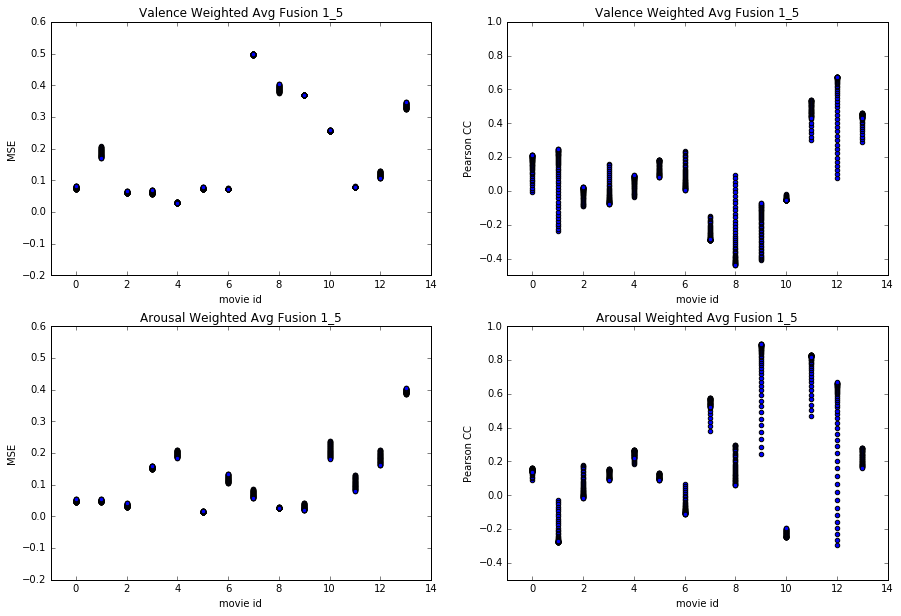

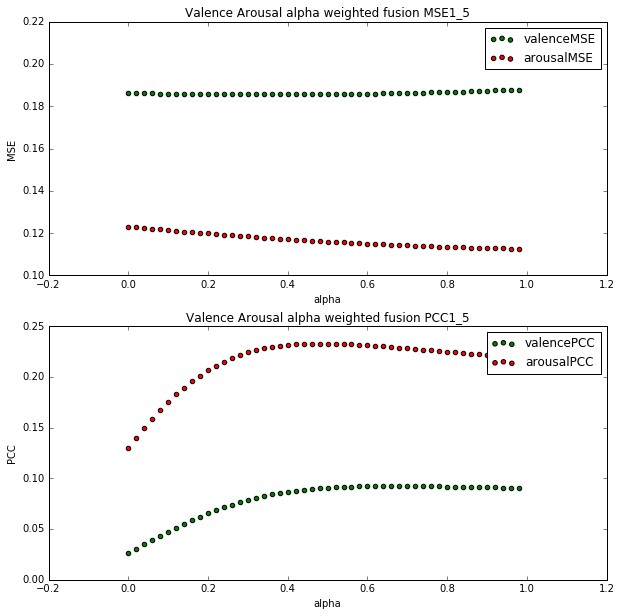

In [35]:
(results_vmse,results_amse,results_vpcc,results_apcc,results_alpha,
 results_valence_mse,results_arousal_mse,
 results_valence_pearson,
 results_arousal_pearson) = dict_results['1_5']
showres('1_5')
showalpha('1_5')

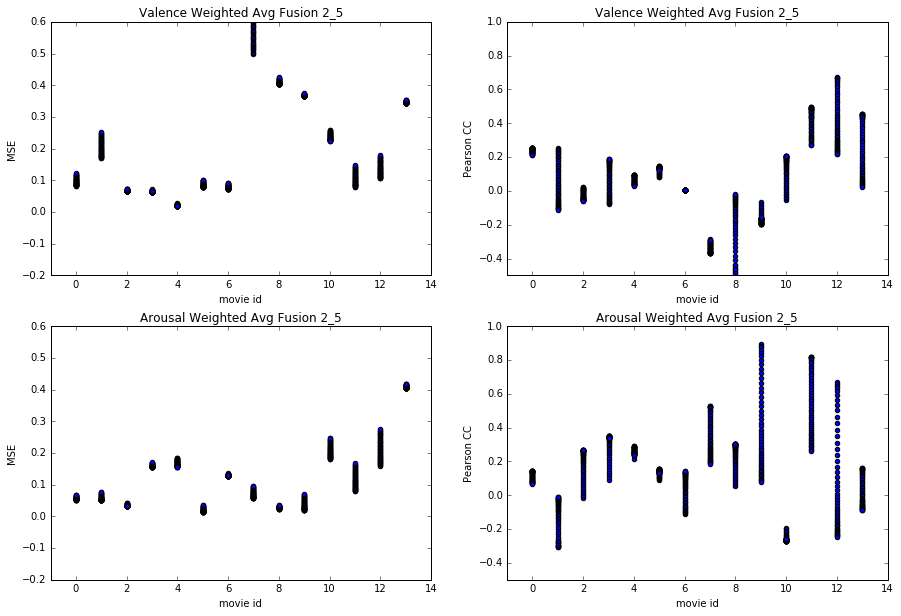

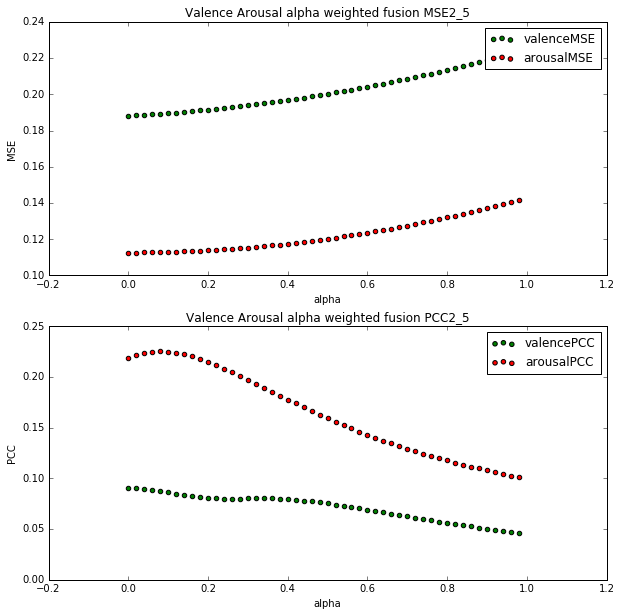

In [36]:
(results_vmse,results_amse,results_vpcc,results_apcc,results_alpha,
 results_valence_mse,results_arousal_mse,
 results_valence_pearson,
 results_arousal_pearson) = dict_results['2_5']
showres('2_5')
showalpha('2_5')

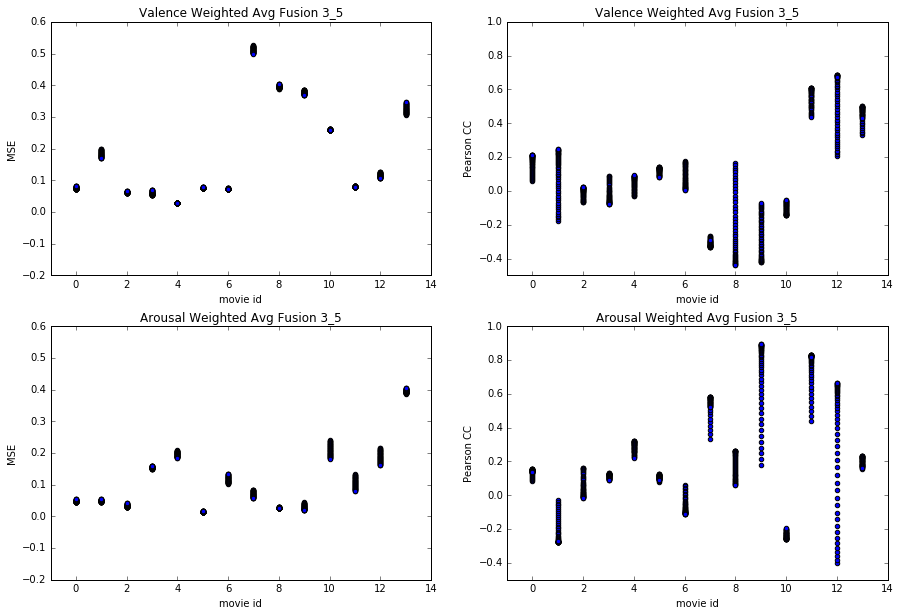

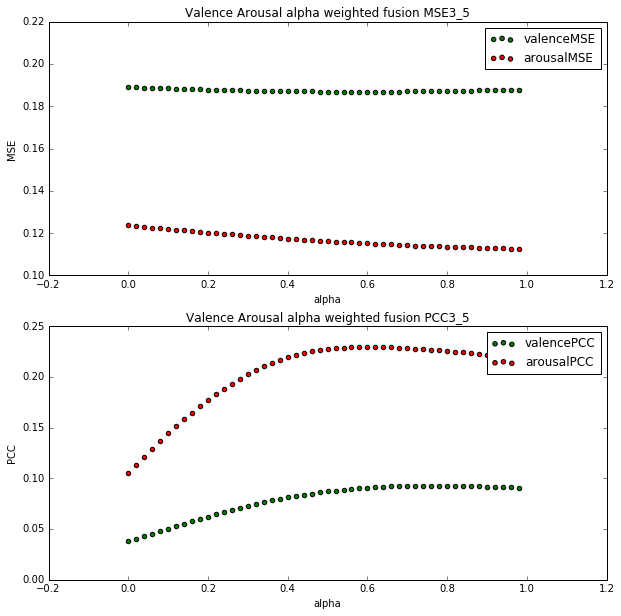

In [37]:
(results_vmse,results_amse,results_vpcc,results_apcc,results_alpha,
 results_valence_mse,results_arousal_mse,
 results_valence_pearson,
 results_arousal_pearson) = dict_results['3_5']
showres('3_5')
showalpha('3_5')

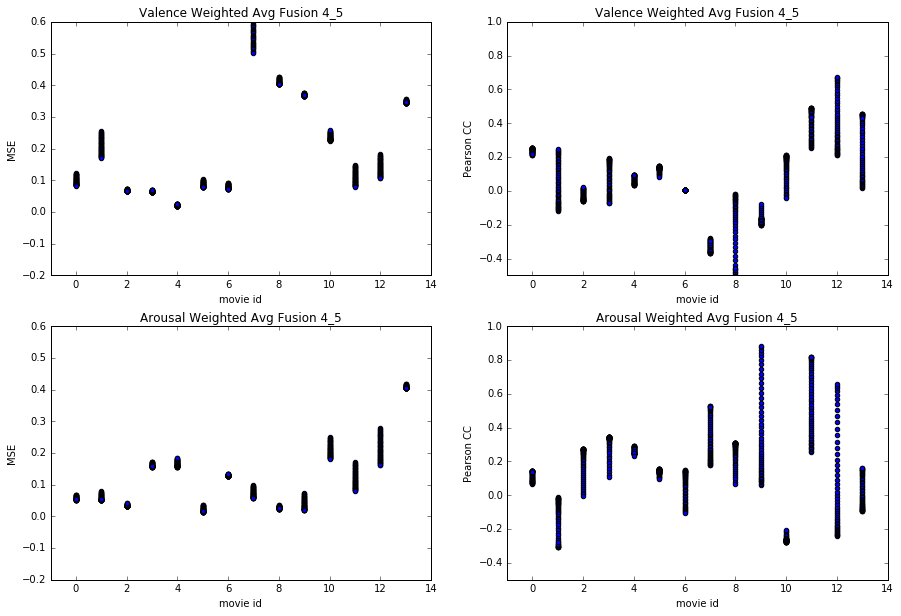

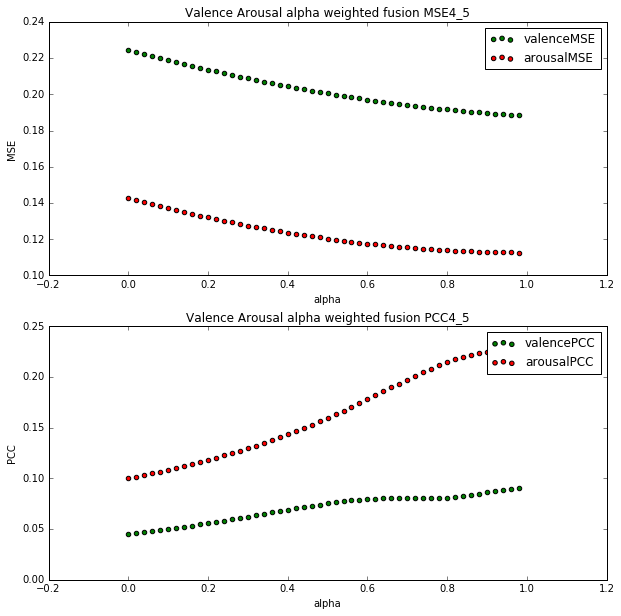

In [38]:
(results_vmse,results_amse,results_vpcc,results_apcc,results_alpha,
 results_valence_mse,results_arousal_mse,
 results_valence_pearson,
 results_arousal_pearson) = dict_results['4_5']
showres('4_5')
showalpha('4_5')

## Utility codes

In [162]:
#results_arousal_pearson
m = max(np.abs(results_arousal_pearson))
i = np.argmax(np.abs(results_arousal_pearson))
m == results_arousal_pearson[i]

True

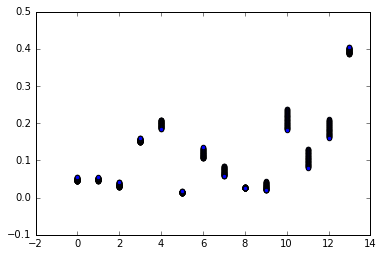

In [132]:
for amse in results_amse:
    plt.scatter(range(len(amse)), amse)    

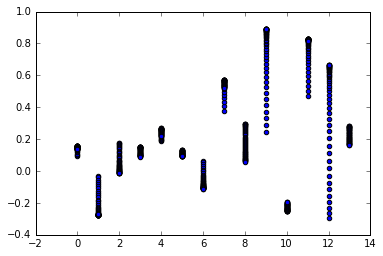

In [130]:
for apcc in results_apcc:
    plt.scatter(range(len(apcc)), apcc)    

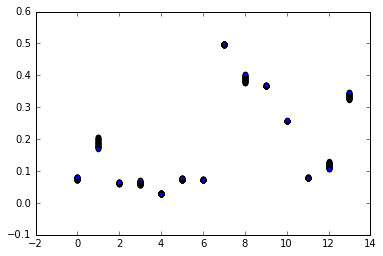

In [131]:
for vmse in results_vmse:
    plt.scatter(range(len(vmse)), vmse)    

In [141]:
a =[ 99, 44,1 , 3,7, 9992,10 ]
a[np.argmin(a)]

1

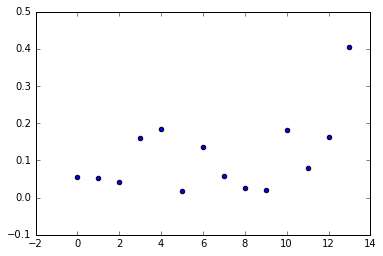

In [109]:
plt.plot(arousal_mse)
plt.scatter(range(len(arousal_mse)), arousal_mse)

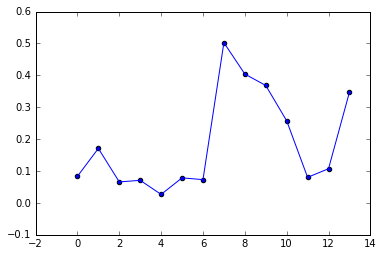

In [108]:
plt.plot(valence_mse)
plt.scatter(range(len(valence_mse)), valence_mse)

In [111]:
[len(i) for i in [results_alpha,
results_valence,
results_arousal,
results_valence_mse,
results_arousal_mse,
results_valence_pearson,
results_arousal_pearson]]

[50, 50, 50, 50, 50, 50, 50]

In [117]:
[str(i) for i in [results_alpha[0],
results_valence[0],
results_arousal[0],
results_valence_mse[0],
results_arousal_mse[0],
results_valence_pearson[0],
results_arousal_pearson[0]]]

['0.0',
 '[0.12277721400159083, 0.2548318046972326, 0.073841100175977059, 0.068072944532004437, 0.020733863731039161, 0.10293285533111671, 0.091937468730820399, 0.69607351583250865, 0.42686200642075056, 0.37597766838686592, 0.22559410141886621, 0.14859551953810732, 0.18156935995390991, 0.35605010917532365]',
 '[0.068383692501522514, 0.078909118404499073, 0.03267586535826543, 0.17289644816124836, 0.15619254104859373, 0.036628402588645796, 0.13146248727823323, 0.098068961238887697, 0.035057468835960795, 0.072903576271154999, 0.24968773985655274, 0.17116329945482189, 0.27871668468566724, 0.41725296609860518]',
 '0.224703537995',
 '0.142857089413',
 '0.0448280436629',
 '0.100117156101']

In [38]:
[type(i) for i in [names_gt, valence_gt, arousal_gt]]

[list, list, list]

In [39]:
[len(i) for i in [names_gt, valence_gt, arousal_gt]]

[14, 14, 14]

In [49]:
[type(i) for i in [fusedvallist, fusedarlist]]

[list, list]

In [50]:
[len(i) for i in [fusedvallist, fusedarlist]]

[14, 14]

In [62]:
[len(i) for i in fusedvallist]

[702, 167, 943, 1091, 151, 1251, 1117, 41, 40, 41, 41, 41, 41, 41]

In [63]:
[len(i) for i in valence_gt]

[702, 168, 943, 1091, 151, 1251, 1117, 41, 41, 41, 41, 41, 41, 41]

In [43]:
test = 'MEDIAEVAL17_00'
minv = min([ len(dict_val[i][test]) for i in dict_val])
x = [ dict_val[i][test][0:minv] for i in dict_val]
len(x[1])

702

In [91]:
[i for i in xrange(0,100,5)]

[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95]